In [31]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State update </h1>

In [32]:
def update_state(c,b1,b2,omega_tab,gamma,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k1, 1_k2, 0>
    b (np array): Atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * np.sqrt(gamma/(2*L)) * np.exp(-1j * (omega_tab - omega_A) * t) 
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))


    c_new = b1[:,np.newaxis] @ np.conjugate(g_matrix[np.newaxis,:]) + np.conjugate(g_matrix[:,np.newaxis]) @ b2[np.newaxis,:] 
    b1_new = c @ g_matrix
    b2_new = g_matrix @ c

    return -1j* dt * c_new, -1j * dt * b1_new, -1j * dt * b2_new

def RG_scheme(c_init, b1_init, b2_init, omega_tab, gamma, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k1, 1_k2, 0>
    b_init (np array): initial atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(omega_tab)
    c_array = np.zeros((nb_pts_time, 2*n_modes, 2*n_modes), dtype=complex)
    b1_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)
    b2_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b1_array[0] = b1_init
    b2_array[0] = b2_init
    
    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b1_current = b1_array[i-1]
        b2_current = b2_array[i-1]

        c_new_k1, b1_new_k1, b2_new_k1 = update_state(c_current, b1_current, b2_current, omega_tab, gamma, omega_A, L, t, dt)
        c_new_k2, b1_new_k2, b2_new_k2 = update_state(c_current + c_new_k1/2, b1_current + b1_new_k1/2, b2_current + b2_new_k1/2, omega_tab, gamma, omega_A, L, t + dt/2, dt)
        c_new_k3, b1_new_k3, b2_new_k3  = update_state(c_current + c_new_k2/2, b1_current + b1_new_k2/2, b2_current + b2_new_k2/2, omega_tab, gamma, omega_A, L, t + dt/2, dt)
        c_new_k4, b1_new_k4, b2_new_k4 = update_state(c_current + c_new_k3, b1_current + b1_new_k3, b2_current + b2_new_k3, omega_tab, gamma, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b1_new = b1_current + (b1_new_k1 + 2*b1_new_k2 + 2*b1_new_k3 + b1_new_k4) / 6
        b2_new = b2_current + (b2_new_k1 + 2*b2_new_k2 + 2*b2_new_k3 + b2_new_k4) / 6

        c_array[i] = c_new
        b1_array[i] = b1_new
        b2_array[i] = b2_new

    return c_array, b1_array, b2_array 
    

<h1> Function that treats the whole evolution </h1>

In [5]:
def get_data_bs_fast(L, T, dt, omega_0, omega_A, gamma, omega_min, omega_max, delta_k, x_0, x_1, print_info = False, progress_bar=True):
    """
    Generate data for the RG scheme with a beamsplitter.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the first Gaussian peak.
    x_1 (float): Position of the second Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k1, 1_k2, 0>.
    b_array (np array): Coefficients in front of the state |1_k, 1>.
    overlap_tab (np array): Array of overlaps with the initial state.
    """
    
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if (2*pi*n/L >= omega_min and 2*pi*n/L <= omega_max)])
    k_tab_individual = np.copy(omega_tab_p) #only positive modes
    n_modes = len(k_tab_individual) #number of modes in each waveguide
    omega_tab_individual = np.abs(k_tab_individual)

    if print_info:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    if print_info:
        print("Preparing the initial state...")
    c_init = np.zeros((2*n_modes, 2*n_modes), dtype=complex)
    b1_init = np.zeros(2*n_modes, dtype=complex)
    b2_init = np.zeros(2*n_modes, dtype=complex)


    c_a_individual = np.exp(-(k_tab_individual - omega_0)**2 /(4*delta_k**2)) * np.exp(-1j * k_tab_individual * x_0)
    c_a = np.concatenate((c_a_individual, np.zeros(n_modes))) #put it in the first waveguide

    c_b_individual = np.exp(-(k_tab_individual - omega_0)**2 /(4*delta_k**2)) * np.exp(-1j * k_tab_individual * x_1)
    c_b = np.concatenate((np.zeros(n_modes), c_b_individual)) #put it in the second waveguide

    c_init = c_a[:, np.newaxis] * c_b[np.newaxis, :]
    c_init = (c_init + c_init.T)
    norm = np.sqrt(np.sum(np.abs(c_init)**2))
    c_init /= norm

    ##evolve the state
    if print_info:
        print("Evolving the state...")
    c_array, b1_array, b2_array = RG_scheme(c_init, b1_init, b2_init, omega_tab_individual, gamma, omega_A, L, T, dt, progress_bar=progress_bar)


    return c_array, b1_array, b2_array, k_tab_individual

<h1> First test </h1>

Some checks

In [26]:
L = 20*pi
T = L/2
dt = 0.01

#Bare parameters
gamma = 8
omega_A = 10
omega_min = 0
omega_max = 20

#renormalized parameters
prefactor = 1/(1 + gamma/(2*pi)*(1/(omega_min - omega_A) - 1/(omega_max - omega_A)))
if prefactor < 0:
    raise ValueError("Prefactor is negative, unphysical parameters.")
print("Renormalization prefactor: ", prefactor)
#prefactor = 1
omega_A_phys = omega_A - gamma / (2*pi) * np.log((omega_max-omega_A)/(omega_A - omega_min)) * prefactor
gamma_phys = gamma * prefactor
print("Physical atomic frequency omega_A_phys: ", omega_A_phys)
print("Physical decay rate gamma_phys: ", gamma_phys)
print("----------------------------")


#initial photonic wave packet
omega_0 = omega_A_phys - 1*gamma_phys/2
print("Photon frequency omega_0: ", omega_0)
x_0 = -L/4
x_1 = -L/4

delta_k = 0.01*gamma
delta_x = 1/(2*delta_k)
print("delta_x / L = ", delta_x / L)


#save the parameters
save_param = False

if save_param:
    data = {
        'L' : L,
        'gamma': gamma,
        'dt': dt,
        'omega_A': omega_A,
        'omega_0': omega_0,
        'omega_max': omega_max,
        'delta_k': delta_k
    }
    df = pd.DataFrame(data, index=[0])
    current_filename = f"two_photon_example_param.csv"
    df.to_csv(current_filename, index=False)

Renormalization prefactor:  1.3416478091411652
Physical atomic frequency omega_A_phys:  10.0
Physical decay rate gamma_phys:  10.733182473129322
----------------------------
Photon frequency omega_0:  4.633408763435339
delta_x / L =  0.0994718394324346


Run the calculations

In [27]:
c_array, b1_array, b2_array, k_tab_individual = get_data_bs_fast(L, T, dt, omega_0, omega_A, gamma, omega_min, omega_max, delta_k, x_0, x_1, print_info = False, progress_bar=True)

  0%|          | 0/3140 [00:00<?, ?it/s]

<h1> Coherence and atom excitation </h1>

In [29]:
time_array = np.linspace(0, T, int(T / dt))
nb_pts_time = int(T / dt)
n_modes = c_array.shape[1] // 2

c_11 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_12 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_21 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_22 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)

p_11 = np.zeros(nb_pts_time)
p_12 = np.zeros(nb_pts_time)
p_21 = np.zeros(nb_pts_time)
p_22 = np.zeros(nb_pts_time)

atom_excitation = np.zeros(nb_pts_time)
#get the number of modes

for i in tqdm(range(nb_pts_time)):
    c_current, b1_current, b2_current = c_array[i], b1_array[i], b2_array[i]

    atom_excitation[i] = np.sum(np.abs(b1_current)**2) + np.sum(np.abs(b2_current)**2)
    p_11[i] = np.sum(np.abs(c_current[:n_modes, :n_modes])**2)
    p_12[i] = np.sum(np.abs(c_current[:n_modes, n_modes:])**2)
    p_21[i] = np.sum(np.abs(c_current[n_modes:, :n_modes])**2)
    p_22[i] = np.sum(np.abs(c_current[n_modes:, n_modes:])**2)

  0%|          | 0/3141 [00:00<?, ?it/s]

anti HOM probability  0.019313606938210104


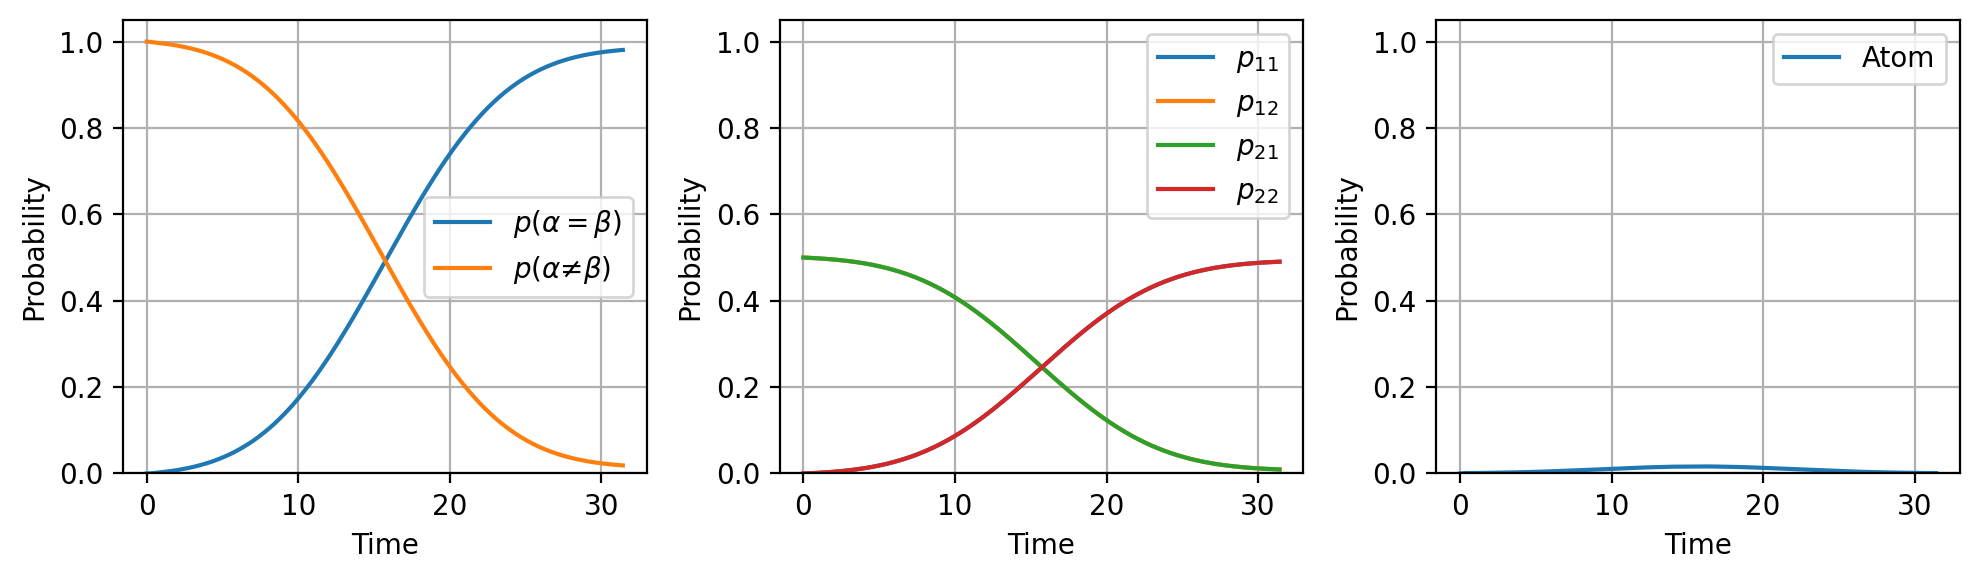

In [30]:
#anti HOM dip
print("anti HOM probability ", 1 - p_11[-1] - p_22[-1])

fig, ax = plt.subplots(1,3, figsize=(10,3), dpi=resol)

ax[0].plot(time_array, p_11 + p_22, label=r'$p(\alpha = \beta)$')
ax[0].plot(time_array, p_12 + p_21, label=r'$p(\alpha \ne \beta)$')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()
ax[0].set_ylim([0,1.05])


ax[1].plot(time_array, p_11, label="$p_{11}$")
ax[1].plot(time_array, p_12, label="$p_{12}$")
ax[1].plot(time_array, p_21, label="$p_{21}$")
ax[1].plot(time_array, p_22, label="$p_{22}$")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Probability')
ax[1].legend()
ax[1].grid()
ax[1].set_ylim([0,1.05])


ax[2].plot(time_array, atom_excitation,label='Atom')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Probability')
ax[2].legend()
ax[2].grid()
ax[2].set_ylim([0,1.05])

fig.tight_layout()
plt.show()

Visualize wave function in both channels

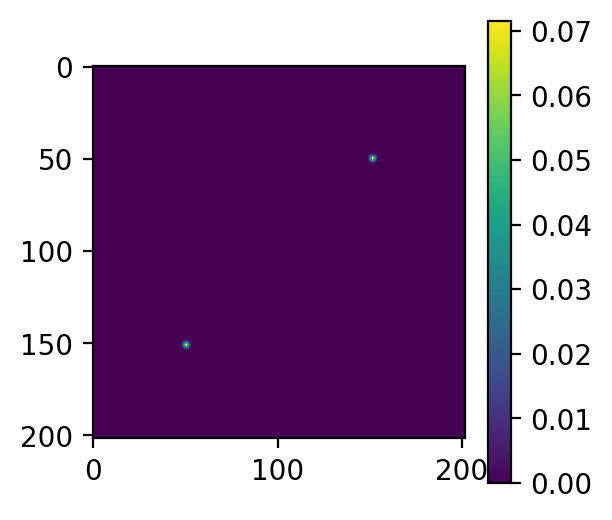

In [221]:
time_index = -1
c_current = c_array[time_index]
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
im = ax.imshow(np.abs(c_current)**2)
plt.colorbar(im, ax=ax)
plt.show()

<h1> Verify concistency physical frequency ? </h1>

Check the probabily $P_{anti, HOM}$ against the incoming photon's frequency

In [322]:
L = 50*pi
T = L/2
dt = 0.01

#Bare parameters
gamma = 1
omega_A = 10
omega_min = 8
omega_max = 12

#renormalized parameters
prefactor = 1/(1 + gamma/(2*pi)*(1/(omega_min - omega_A) - 1/(omega_max - omega_A)))
if prefactor < 0:
    raise ValueError("Prefactor is negative, unphysical parameters.")
print("Renormalization prefactor: ", prefactor)
print("Physical atomic frequency omega_A_phys: ", omega_A_phys)
print("Physical decay rate gamma_phys: ", gamma_phys)
print("----------------------------")

omega_A_phys = omega_A - gamma / (2*pi) * np.log((omega_max-omega_A)/(omega_A - omega_min)) * prefactor
gamma_phys = gamma * prefactor


#initial photonic wave packet
omega_0_5050_m = omega_A_phys - gamma_phys/2
omega_0_5050_p = omega_A_phys + gamma_phys/2
print("50/50 reflexion: ", omega_0_5050_m, omega_0_5050_p)
x_0 = -L/4
x_1 = -L/4
delta_k = 0.05*gamma

Renormalization prefactor:  1.1892797511079254
Physical atomic frequency omega_A_phys:  10.0
Physical decay rate gamma_phys:  1.46694220692426
----------------------------
50/50 reflexion:  9.405360124446037 10.594639875553963


In [323]:
nb_pts_freq = 15

omega_0_tab = np.linspace((3*omega_min + omega_0_5050_m)/4 , (3*omega_max + omega_0_5050_p)/4, nb_pts_freq)
p_anti_hom_tab = np.zeros(nb_pts_freq)

for i in tqdm(range(nb_pts_freq)):
    omega_0 = omega_0_tab[i]
    print("Computing evolution for omega_0 = %.2f" % omega_0)
    c_array, b1_array, b2_array, k_tab_individual = get_data_bs_fast(L, T, dt, omega_0, omega_A, gamma, omega_min, omega_max, delta_k, x_0, x_1, print_info = False, progress_bar=False)
    n_modes = len(k_tab_individual)
    p_11_final = np.sum(np.abs(c_array[-1,:n_modes, :n_modes])**2)
    p_22_final = np.sum(np.abs(c_array[-1,n_modes:, n_modes:])**2)
    p_anti_hom_tab[i] = 1 - p_11_final - p_22_final


  0%|          | 0/15 [00:00<?, ?it/s]

Computing evolution for omega_0 = 8.35
Computing evolution for omega_0 = 8.59
Computing evolution for omega_0 = 8.82
Computing evolution for omega_0 = 9.06
Computing evolution for omega_0 = 9.29
Computing evolution for omega_0 = 9.53
Computing evolution for omega_0 = 9.76
Computing evolution for omega_0 = 10.00
Computing evolution for omega_0 = 10.24
Computing evolution for omega_0 = 10.47
Computing evolution for omega_0 = 10.71
Computing evolution for omega_0 = 10.94
Computing evolution for omega_0 = 11.18
Computing evolution for omega_0 = 11.41
Computing evolution for omega_0 = 11.65


Plot the results and compare with theory

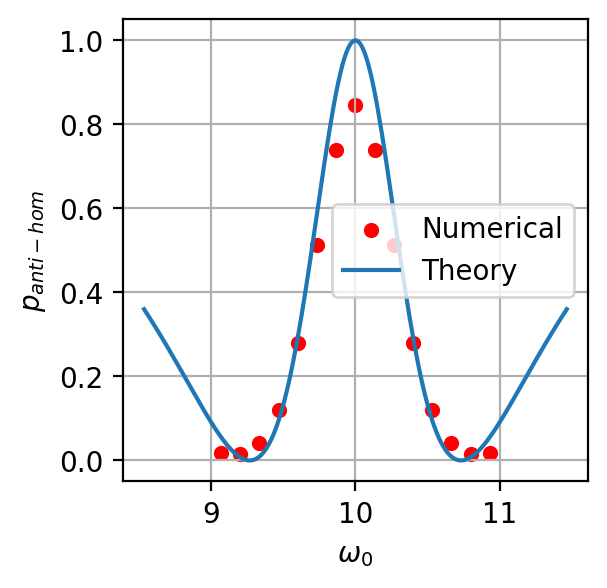

In [309]:
omega_0_theory = np.linspace(omega_A_phys - gamma_phys, omega_A_phys + gamma_phys, 200)
p_anti_hom_tab_theory = 1 - (4 * (omega_0_theory - omega_A_phys)**2 /(gamma_phys / 2)**2) / (1 + (omega_0_theory - omega_A_phys)**2 /(gamma_phys / 2)**2)**2

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

ax.scatter(omega_0_tab, p_anti_hom_tab, label="Numerical", marker='o', s=20, color="red")
ax.plot(omega_0_theory, p_anti_hom_tab_theory, '-', label="Theory")
ax.set_xlabel(r"$\omega_0$")
ax.set_ylabel(r"$p_{anti-hom}$")
ax.grid()
ax.legend()
plt.show()

Find the minimum and compare with my prediction

In [317]:
omega_0_5050_phys = omega_0_tab[np.argmin(np.abs(p_anti_hom_tab - 0))]

if omega_0_5050_phys > omega_A_phys:
    omega_0_5050_m_phys = 2*omega_A_phys - omega_0_5050_phys
    omega_0_5050_p_phys = omega_0_5050_phys
else:
    omega_0_5050_m_phys = omega_0_5050_phys
    omega_0_5050_p_phys = 2*omega_A_phys - omega_0_5050_phys

print("Minimum at omega_0_m = %.4f and omega_0_p = %.4f" % (omega_0_5050_m_phys, omega_0_5050_p_phys))
print("Predicted 50/50 at omega_0_m = %.4f and omega_0_p = %.4f" % (omega_0_5050_m, omega_0_5050_p))

Minimum at omega_0_m = 9.2000 and omega_0_p = 10.8000
Predicted 50/50 at omega_0_m = 9.2665 and omega_0_p = 10.7335
